## Description:

Monte Carlo Pricer for Vanilla, Barrier, Binary and one specific case of Autocall under  Black Scholes/Heston/Rough Bergomi

In [59]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib import pyplot as plt
from rbergomi import rBergomi
from utils import bsinv
vec_bsinv = np.vectorize(bsinv)

\begin{align}
dS_{t} / S_{t}  =\mu  dt+\sigma dW(t) \\
S_{T} =S_{0}*\exp((\mu-\frac{\sigma^2}{2})dt+\sigma W(t))
\end{align}

### Models

In [60]:
#No dividend Models
class Model:
    '''A class forming the basis for the stock price specifications.
    '''
    def __init__(self, S_0, T, r, sigma): 
        self.S_0 = S_0
        self.T = T
        self.r = r
        self.sigma = sigma
    
class Black_Scholes_Model:
    
    def __init__(self, S_0, T, r, sigma): #N=number of sims
        self.T = T
        self.r = r
        self.S_0 = S_0
        self.sigma = sigma
        
    def simulate_stock_price(self, steps, N): #risk_neutral_stock_path simulation
        """SDE $$dX = \r dt +\simga dW$$ according to the risk neutral measure"""
        dt = T/steps #N=number of sims #steps=number of steps until maturity
        mu = (self.r - ((self.sigma*self.sigma)/2))
        sd = self.sigma*np.sqrt(self.T)
        ST = S_0*np.exp(np.cumsum((mu*dt + sigma*np.sqrt(dt)*np.random.normal(size=(steps,N))),axis=0))
        return ST
    
class Heston_Model:
    
    def __init__(self, S_0, T, r, kappa, theta, v_0, rho, xi): #N=number of sims
        self.T = T
        self.r = r
        self.S_0 = S_0
        self.kappa = kappa
        self.theta = theta
        self.v_0 = v_0
        self.rho = rho
        self.xi = xi
        
    def simulate_stock_price(self, steps, N): 
        np.random.seed(12345)
        dt = T/steps
        size = (N, steps)
        prices = np.zeros(size)
        sigs = np.zeros(size)
        S_t = self.S_0
        v_t = v_0
        for t in range(steps):
            WT = np.random.multivariate_normal(np.array([0,0]), 
                                               cov = np.array([[1,rho],
                                                              [rho,1]]), 
                                               size=N) * np.sqrt(dt) 

            S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) ) 
            v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
            prices[:, t] = S_t
            sigs[:, t] = v_t
            prices_transpose = np.transpose(prices)
            sigs_transpose = np.transpose(sigs)

        return prices_transpose
    
class Rough_Bergomi:
    
    def __init__(self, S_0, T, a, rho,xi): #N=number of sims
        self.S_0 = S_0
        self.T = T
        self.a = a
        self.rho = rho
        self.xi = xi
        
    def simulate_stock_price(self, steps, N):
        rB = rBergomi(steps, N, self.T, self.a)
        np.random.seed(0)
        dW1 = rB.dW1()
        dW2 = rB.dW2()
        Y = rB.Y(dW1)
        dB = rB.dB(dW1, dW2, rho)
        V = rB.V(Y, xi, eta) 
        S = rB.S(V, dB,S_0)
        return np.transpose(S) #maybe consider returning S instead of np.transpose(S)


### Pricing functions

In [38]:
class European_Option(Model):
    '''A child class inheriting the stock price specifications from the Model.
    '''
    def __init__(self,K,Option_Type): 
        Model.__init__(self, S_0, T, r, sigma)
        self.K = K
        self.Option_Type = Option_Type
                
        
    def MC(self,model,steps,N): #passing func as Model e.g Black Scholes
        if (self.Option_Type=="Call" or self.Option_Type=="Put"):
            Stock_array = model.simulate_stock_price(steps, N)
            Payoff = np.maximum(Stock_array[-1]-K, 0) if self.Option_Type=="Call" else np.maximum(K-Stock_array[-1], 0)
            return np.mean(Payoff)*np.exp(-r*T) #Mean of discounted Payoff
        else:
            print("Select Call or Put")
    
    #Closed-Form Formula  
    def CF_BS(self):
        d1 = (np.log(S_0 / K) + (r + 0.5*sigma*sigma)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        if self.Option_Type=="Call":
            return S_0*norm.cdf(d1) - np.exp(-r*T)*K*norm.cdf(d2)
        elif self.Option_Type=="Put":
            return -S_0*norm.cdf(-d1) + np.exp(-r*T)*K*norm.cdf(-d2)
        else:
            print('Select right Option')
    
class Binary_Option(Model):

    def __init__(self,B,Option_Type): 
        Model.__init__(self, S_0, T, r, sigma)
        self.B = B
        self.Option_Type = Option_Type
                
        
    def MC(self,model,steps,N): #passing func as Model e.g Black Scholes
        if (self.Option_Type=="Call" or self.Option_Type=="Put"):
            Stock_array = model.simulate_stock_price(steps, N)
            Payoff = np.int64(Stock_array > K) if self.Option_Type=="Call" else np.int64(Stock_array <= K)
            return np.mean(Payoff)*np.exp(-r*T) #Mean of discounted Payoff
        else:
            print("Select Call or Put")
    
    #Closed-Form Formula  
    def CF_BS(self):
        d1 = (np.log(S_0 / K) + (r + 0.5*sigma*sigma)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        if self.Option_Type=="Call":
            return np.exp(-r*T)*norm.cdf(d2)
        elif self.Option_Type=="Put":
            return np.exp(-r*T)*norm.cdf(-d2)
        else:
            print('Select right Option')
            
class Barrier_Option(Model):
    
    def __init__(self,K,B,Option_Type): 
        Model.__init__(self, S_0, T, r, sigma)
        self.K = K
        self.B = B
        self.Option_Type = Option_Type
    
    def MC_DO(self,model,steps,N):
        if (self.Option_Type=="Call" or self.Option_Type=="Put"):
            Stock_array = model.simulate_stock_price(steps, N)
            Payoff = np.zeros([1,N])
            if (S_0<B): #Assuming observation on trading date
                return "0 (S_0<B, option worthless)"
            else:
                for i in range(0,N):#N
                    if np.min(Stock_array[:,i]) < B: #i.e if running min below B, option KO
                        #Quick comment on tree, with N along x axis and steps along y axis
                        Payoff[:,i] = 0
                    else:
                        Payoff[:,i] = np.maximum(Stock_array[steps-1,i]-K, 0) if self.Option_Type=="Call" else \
                        np.maximum(K-Stock_array[steps-1,i], 0) 
                return np.mean(Payoff)*np.exp(-r*T)
            
        else:
            print("Select Call or Put")
    
    def MC_UO(self,model,steps,N):
        if (self.Option_Type=="Call" or self.Option_Type=="Put"):
            Stock_array = model.simulate_stock_price(steps, N)       
            Payoff = np.zeros([1,N])
            if (S_0>B): #Assuming observation on trading date
                return "0 (S_0>B, option worthless)"
            else:
                for i in range(0,N):#N
                    if np.max(Stock_array[:,i]) > B: #i.e if running max over B, option KO
                        #Quick comment on tree, with N along x axis and steps along y axis
                        Payoff[:,i] = 0
                    else:
                        #Payoff[:,i] = np.maximum(Stock_array[steps-1,i]-K, 0)
                        Payoff[:,i] = np.maximum(Stock_array[steps-1,i] - K, 0) if self.Option_Type=="Call" else \
                        np.maximum(K-Stock_array[steps-1,i], 0) 
            return np.mean(Payoff)*np.exp(-r*T)
        else:
            print("Select Call or Put")
    
    #Can use In/Out Parity to compute prices below
    def MC_DI(self,model,steps,N):
        if (self.Option_Type=="Call" or self.Option_Type=="Put"):
            Stock_array = model.simulate_stock_price(steps, N)
            Payoff = np.zeros([1,N])
            if (S_0<B): #Assuming observation on trading date
                return European_Option(K,self.Option_Type).MC(model,steps, N)
            else:
                for i in range(0,N):#N
                    if np.min(Stock_array[:,i]) < B: #i.e if running min below B, option KO
                        #Quick comment on tree, with N along x axis and steps along y axis
                        Payoff[:,i] = np.maximum(Stock_array[steps-1,i]-K, 0) if self.Option_Type=="Call" else \
                        np.maximum(K-Stock_array[steps-1,i], 0) 
                    else:
                        Payoff[:,i] = 0
                return np.mean(Payoff)*np.exp(-r*T)
            
        else:
            print("Select Call or Put")
    
    def MC_UI(self,model,steps,N):    
        if (self.Option_Type=="Call" or self.Option_Type=="Put"):
            Stock_array = model.simulate_stock_price(steps, N)
            Payoff = np.zeros([1,N])
            if (S_0>B): #Assuming observation on trading date
                return European_Option(K,self.Option_Type).MC(model,steps, N)
            else:
                for i in range(0,N):#N
                    if np.max(Stock_array[:,i]) > B: #i.e if running min below B, option KO
                        #Quick comment on tree, with N along x axis and steps along y axis
                        Payoff[:,i] = np.maximum(Stock_array[steps-1,i]-K, 0) if self.Option_Type=="Call" else \
                        np.maximum(K-Stock_array[steps-1,i], 0) 
                    else:
                        Payoff[:,i] = 0
                return np.mean(Payoff)*np.exp(-r*T)
            
        else:
            print("Select Call or Put")
            
class Autocallable(Model):
    def __init__(self,K): 
        Model.__init__(self, S_0, T, r, sigma)
        self.K = K
        
        
    def Pricer_AC(self,model,B_C, B_AC, Coupon_level, steps, N):
        steps = T*364 #discretizing the space with 364 steps such that each step represents a day
        paths = model.simulate_stock_price(steps, N)
        Payoff = 0
        Payoff_list = []

        for sim in range(0,N):
            Payoff = 0
            for t_i in range(Obs_date-1,steps,Obs_date): #t_i in steps, sim in N
                if t_i != (steps - 1) :
                    if B_C < paths[t_i,sim] < B_AC:
                        Payoff += Coupon_level * self.S_0
                        Payoff *=math.exp(-r*t_i/364) #Discounting CF
                    elif paths[t_i,sim] <= B_C:
                        Payoff += 0
                    elif B_AC <=paths[t_i,sim]:
                        Payoff += S_0 + Coupon_level * self.S_0 # gets notional back + Coupon paid
                        Payoff *=math.exp(-r*t_i/364)
                        break
                elif t_i == (steps - 1) :
                    Payoff += - np.maximum(K - paths[t_i,sim],0)*np.int64(paths[t_i,sim] < B_C) + \
                              np.int64(paths[t_i,sim] > B_C) * Coupon_level * self.S_0 + self.S_0
                    Payoff *=math.exp(-r*t_i/364)
            Payoff_list.append(Payoff)

        Av_Payoff = sum(Payoff_list) / len(Payoff_list)
        return Av_Payoff
    
    def Pricer_AC_basic(self,model, C, B_DIP, B_AC, Coupon_level, steps, N): #1Y AC at 6M
        steps = T*364 #discretizing the space with 364 steps such that each step represents a day
        paths = model.simulate_stock_price(steps, N)
        Payoff = 0
        Payoff_list = []

        for sim in range(0,N):
            ST = paths[-1,sim]
            indicator_AC = np.maximum(np.sign(paths[int(steps/2),sim] - B_AC),0.)
            indicator_DIP = np.maximum(np.sign(B_DIP-ST),0.)
            c = S_0*C
            Payoff = (S_0 + c)*(indicator_AC) \
                   +(S_0 + c)*(1-indicator_AC) -np.maximum(K - ST,0.)\
                   *(indicator_DIP)*(1-indicator_AC)
            Payoff_list.append(Payoff)

        Av_Payoff = sum(Payoff_list) / len(Payoff_list)
        return Av_Payoff
    
    def Pricer_AC_continuous(self,model, C, B_DIP, B_AC, Coupon_level, steps, N): #1Y AC at 6M
        steps = T*364 #discretizing the space with 364 steps such that each step represents a day
        paths = model.simulate_stock_price(steps, N)
        Payoff = 0
        Payoff_list = []

        for sim in range(0,N):        
            ST = paths[-1,sim]
            pmax = np.max(paths[:,sim])
            pmin = np.min(paths[:,sim]) #running minimum
            indicator_AC_cont = np.maximum(np.sign(pmax-B_AC),0.) #1 if running max>B_AC, 0 otherwise
            indicator_DIP = np.maximum(np.sign(B_DIP-pmin),0.)
            c = S_0*C
            Payoff = (S_0 + c)*(indicator_AC_cont) \
                  +(S_0 + c)*(1-indicator_AC_cont) -np.maximum(K - ST,0.)\
                  *(indicator_DIP)*(1-indicator_AC_cont)
            Payoff_list.append(Payoff)
          #print(pmin)

        Av_Payoff = sum(Payoff_list) / len(Payoff_list)
        return Av_Payoff




## Cont. Autocall

In [1]:
## B= 1.2

In [ ]:
#Product Features
S_0, T, K, B_AC, B_DIP, C = 1, 1, 1, 1.20, 0.70, 0.03
#BS
sigma, r  = 0.5, 0
black_scholes = Black_Scholes_Model(S_0, T, r, sigma)
#Heston
kappa, theta, v_0, xi, rho = 3, 0.04, sigma**2, 0.6, -0.8
heston = Heston_Model(S_0, T, r, kappa, theta, v_0, rho, xi)
#rBergomi
a, eta = -0.43, 1.9
r_bergomi = Rough_Bergomi(S_0, T, a, rho,xi)

Autocall = Autocallable(K)
#Model Simulation
steps, N = 100, 100000 

print("-------------------")
print("Barrier Autocall=",B_AC, ",Barrier DIP=", B_DIP, ",Coupon level p.a=", 2*C*S_0,"%")
print("-------------------")

print("MC Pricer Autocall BS=", Autocall.Pricer_AC_continuous(black_scholes,C, B_DIP, B_AC, C, steps, N))
print("MC Pricer Autocall Heston=", Autocall.Pricer_AC_continuous(heston,C, B_DIP, B_AC, C, steps, N))
print("MC Pricer Autocall rBergomi=", Autocall.Pricer_AC_continuous(r_bergomi,C, B_DIP, B_AC, C, steps, N))

In [2]:
## B=1.3

In [ ]:
#Product Features
S_0, T, K, B_AC, B_DIP, C = 1, 1, 1, 1.30, 0.70, 0.03
#BS
sigma, r  = 0.5, 0
black_scholes = Black_Scholes_Model(S_0, T, r, sigma)
#Heston
kappa, theta, v_0, xi, rho = 3, 0.04, sigma**2, 0.6, -0.8
heston = Heston_Model(S_0, T, r, kappa, theta, v_0, rho, xi)
#rBergomi
a, eta = -0.43, 1.9
r_bergomi = Rough_Bergomi(S_0, T, a, rho,xi)

Autocall = Autocallable(K)
#Model Simulation
steps, N = 100, 100000 

print("-------------------")
print("Barrier Autocall=",B_AC, ",Barrier DIP=", B_DIP, ",Coupon level p.a=", 2*C*S_0,"%")
print("-------------------")

print("MC Pricer Autocall BS=", Autocall.Pricer_AC_continuous(black_scholes,C, B_DIP, B_AC, C, steps, N))
print("MC Pricer Autocall Heston=", Autocall.Pricer_AC_continuous(heston,C, B_DIP, B_AC, C, steps, N))
print("MC Pricer Autocall rBergomi=", Autocall.Pricer_AC_continuous(r_bergomi,C, B_DIP, B_AC, C, steps, N))

### SIMPLE AC With 6M AC and 1Y Maturity: Monte Carlo

In [83]:
#Product Features
S_0, T, K, B_AC, B_DIP, C,  = 1, 1, 1, 1.20, 0.70, 0.03
Autocall = Autocallable(K)
#BS
sigma, r  = 0.5, 0
black_scholes = Black_Scholes_Model(S_0, T, r, sigma)
#Heston
kappa, theta, v_0, xi, rho = 3, 0.04, sigma**2, 0.6, -0.8
heston = Heston_Model(S_0, T, r, kappa, theta, v_0, rho, xi)
#rBergomi
a, eta = -0.43, 1.9
r_bergomi = Rough_Bergomi(S_0, T, a, rho,xi)


#Model Simulation
steps, N = 100, 100000 

print("-------------------")
print("Barrier Autocall=",B_AC, ",Barrier DIP=", B_DIP, ",Coupon level p.a=", 2*C*S_0,"%")
print("-------------------")

print("MC Pricer Autocall BS=", Autocall.Pricer_AC_basic(black_scholes,C, B_DIP, B_AC, C, steps, N))
print("MC Pricer Autocall Heston=", Autocall.Pricer_AC_basic(heston,C, B_DIP, B_AC, C, steps, N))
print("MC Pricer Autocall rBergomi=", Autocall.Pricer_AC_basic(r_bergomi,C, B_DIP, B_AC, C, steps, N))

-------------------
Barrier Autocall= 1.2 ,Barrier DIP= 0.7 ,Coupon level p.a= 0.06 %
-------------------
MC Pricer Autocall BS= 0.8805068492131419
MC Pricer Autocall Heston= 0.9536745494619515
MC Pricer Autocall rBergomi= 0.8289792206527462


### Vanilla + Digit + Barrier under BS, Heston, and rough Bergomi

In [5]:
#Black Scholes
S_0 = 80 #stock price S_{0}
K = 120 # strike
B = 100
T = 1 # time to maturity
r = 0.05 # risk free risk in annual %
sigma = 0.25 # annual volatility in %

#Heston
kappa =3
theta = 0.04
v_0 =  0.04
xi = 0.6
rho = -0.8

#rBergomi
a = -0.43
eta = 1.9

#Model Simulation
steps = 365 # time steps
N = 2000 # number of trials

black_scholes = Black_Scholes_Model(S_0, T, r, sigma)
heston = Heston_Model(S_0, T, r, kappa, theta, v_0, rho, xi)
r_bergomi = Rough_Bergomi(S_0, T, a, rho,xi)

print("-------------EU_Put----------------")
EU_Put = European_Option(K,"Put")
print("Put with MC:", EU_Put.MC(black_scholes,100, 10000))
print("Put with BS:",EU_Put.CF_BS())
print("-----------------------------")
print("")

print("-------------EU_Call----------------")
EU_Call = European_Option(K,"Call")
print("Call with MC:", EU_Call.MC(black_scholes,100, 10000))
print("Call with BS:",EU_Call.CF_BS())
print("-----------------------------")
print("")

print("-------------EU_Digi_Put----------------")
EU_Digi_Put = Binary_Option(K,"Put")
print("DigiPut with MC:",EU_Digi_Put.MC(black_scholes,100, 10000))
print("DigiPut with BS:",EU_Digi_Put.CF_BS())
print("-----------------------------")
print("")

print("-------------Call with Barrier----------------")
Call_Barrier = Barrier_Option(K,B,"Call")
print("UOC with MC:",Call_Barrier.MC_UO(black_scholes,365, 20000))
print("UIC with MC:",Call_Barrier.MC_DI(black_scholes,365, 20000))
print("DOC with MC:",Call_Barrier.MC_DO(black_scholes,365, 20000))
print("DIC with MC:",Call_Barrier.MC_DI(black_scholes,365, 20000))
print("-----------------------------")
print("")

print("-------------Put with Barrier----------------")
Put_Barrier = Barrier_Option(K,B,"Put")
print("UOP with MC:",Put_Barrier.MC_UO(black_scholes,365, 20000))
print("UIP with MC:",Put_Barrier.MC_UI(black_scholes,365, 20000))
print("DOP with MC:",Put_Barrier.MC_DO(black_scholes,365, 20000))
print("DIP with MC:",Put_Barrier.MC_DI(black_scholes,365, 20000))
print("")

print("-------------DIP under Heston and rbergomi----------------")
print("DIP with MC under Heston:",Put_Barrier.MC_DI(heston,365, 20000))
print("DIP with MC under rbergomi:",Put_Barrier.MC_DI(r_bergomi,365, 20000))

-------------EU_Put----------------
Put with MC: 34.96823005902147
Put with BS: 34.97758414400147
-----------------------------

-------------EU_Call----------------
Call with MC: 0.7271885115369756
Call with BS: 0.8300532039157851
-----------------------------

-------------EU_Digi_Put----------------
DigiPut with MC: 0.9328754527549727
DigiPut with BS: 0.8932534635851946
-----------------------------

-------------Call with Barrier----------------
UOC with MC: 0.0
UIC with MC: 0.8771967663833014
DOC with MC: 0 (S_0<B, option worthless)
DIC with MC: 0.7617279938192975
-----------------------------

-------------Put with Barrier----------------
UOP with MC: 28.173607020598336
UIP with MC: 6.821207851085891
DOP with MC: 0 (S_0<B, option worthless)
DIP with MC: 34.88651137559409

-------------DIP under Heston and rbergomi----------------
DIP with MC under Heston: 34.05512944598818
DIP with MC under rbergomi: 44.4746196115347


### Autocall with Black Scholes and Heston and rbergomi

In [6]:
Obs_date = 91
Notional = 1    
S_0, K, B_AC, B_C, Coupon_level = 100, 100, 120, 70, 0.012
T= 1
N = 20000
r, sigma = 0, 0.25


print("-------------------")
print("Barrier Autocall=",B_AC, ",Barrier Coupon=", B_C, ",Coupon level p.a=", 4*Coupon_level*S_0,"%")
print("-------------------")

Autocall = Autocallable(K)

print(Autocall.Pricer_AC(black_scholes,B_C, B_AC, Coupon_level, steps, N))
print(Autocall.Pricer_AC(heston,B_C, B_AC, Coupon_level, steps, N))
print(Autocall.Pricer_AC(r_bergomi,B_C, B_AC, Coupon_level, steps, N))

-------------------
Barrier Autocall= 120 ,Barrier Coupon= 70 ,Coupon level p.a= 4.8 %
-------------------
100.61444267619535
94.37425644316866
82.88407273579455


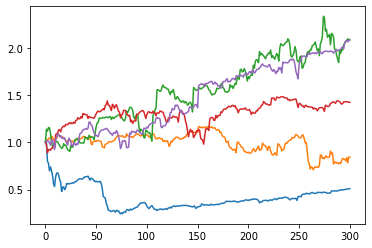

In [69]:
#rBergomi
a = -0.43
eta = 1.9
rho = -0.8
xi = 0.6
r_bergomi = Rough_Bergomi(1, 1, a, -0.8,0.6)
S_BERG = r_bergomi.simulate_stock_price(300, 10)
for i in range(5):
    plt.plot(np.transpose(S_BERG)[i])